In [1]:
import click
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO, DDPG, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    VecVideoRecorder,
    SubprocVecEnv,
)

import matplotlib.pyplot as plt
import imageio
import os
from stable_baselines3.common.env_util import make_vec_env
from typing import Callable, Dict, List
import torch
from wandb.integration.sb3 import WandbCallback
import wandb
import types

from robot_model import CDPR4_env, MAX_EPISODE_STEPS

import sys
# sys.setrecursionlimit(9_999_999)

In [2]:
def linear_schedule(
    initial_value: float, min_value_percent: float = 0.1
) -> Callable[[float], float]:
    """
    Linear learning rate schedule that decreases from initial_value to
    (initial_value * min_value_percent).

    :param initial_value: Initial learning rate
    :param min_value_percent: Final learning rate as a percentage of initial value (0.1 = 10%)
    :return: schedule that computes current learning rate depending on remaining progress
    """

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.
        Learning rate will decrease from initial_value to (initial_value * min_value_percent)

        :param progress_remaining: goes from 1 (beginning) to 0 (end)
        :return: current learning rate
        """
        min_value = initial_value * min_value_percent
        return min_value + (initial_value - min_value) * progress_remaining

    return func


def cosine_schedule_with_warmup(
    initial_value: float,
    warmup_fraction: float = 0.03,
    min_value_percent: float = 0.1,
) -> Callable[[float], float]:
    """
    Cosine learning rate schedule with warmup that decreases from initial_value to
    (initial_value * min_value_percent).

    :param initial_value: Initial learning rate after warmup
    :param warmup_fraction: Fraction of total steps to use for warmup (0.1 = 10%)
    :param min_value_percent: Final learning rate as a percentage of initial value (0.1 = 10%)
    :return: schedule that computes current learning rate depending on remaining progress
    """

    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.
        Learning rate will follow:
        1. Linear warmup from 0 to initial_value for warmup_fraction of total steps
        2. Cosine decay from initial_value to (initial_value * min_value_percent)

        :param progress_remaining: goes from 1 (beginning) to 0 (end)
        :return: current learning rate
        """
        progress_done = 1 - progress_remaining
        min_value = initial_value * min_value_percent

        # Handle warmup phase
        if progress_done < warmup_fraction:
            # Linear warmup
            return initial_value * (progress_done / warmup_fraction)

        # Handle cosine decay phase
        progress_after_warmup = (progress_done - warmup_fraction) / (
            1 - warmup_fraction
        )
        cosine_decay = 0.5 * (1 + np.cos(np.pi * progress_after_warmup))

        # Interpolate between initial_value and min_value using cosine curve
        return min_value + (initial_value - min_value) * cosine_decay

    return func


def get_images(self):
    self.remotes[0].send(("render", None))
    return [self.remotes[0].recv()]


In [3]:
def make_env(is_continuous=False):
    env = Monitor(CDPR4_env(is_continuous=is_continuous))
    return env

In [4]:
def train_model_PPO(
    activation_fn: str = "ReLU",
    net_arch: Dict[str, List[int]] = dict(
        pi=[512, 512],
        vf=[512, 512],
    ),
    lr_initial_value: float = 8e-4,
    warmup_fraction: float = 0.01,
    min_value_percent: float = 0.1,
    batch_size: int = 32,
    n_epochs: int = 5,
    gamma: float = 0.99,
    gae_lambda: float = 0.95,
    clip_range: float = 0.2,
    max_grad_norm: float = 100.0,
    use_sde: bool = False,
    sde_sample_freq: int = -1,
    ent_coef: float = 0.0005,
    # Training parameters
    total_timesteps: int = 1_000_000,
    log_interval: int = 1,
    progress_bar: bool = True,
    record_video: bool = False,
    device: str = "cpu",
):
    activation_fn_map = {
        "ReLU": torch.nn.ReLU,
        "Tanh": torch.nn.Tanh,
        "LeakyReLU": torch.nn.LeakyReLU,
    }
    activation_fn = activation_fn_map[activation_fn]

    env = make_vec_env(
        lambda: make_env(),
        n_envs=int(4),
        vec_env_cls=SubprocVecEnv,
    )
    env.get_images = types.MethodType(get_images, env)
    if record_video:
        env = VecVideoRecorder(
            env,
            f"videos/{wandb.run.id}",
            record_video_trigger=lambda x: x % 100 == 0,
            video_length=MAX_EPISODE_STEPS * 3,
        )

    policy_kwargs = dict(
        log_std_init=-2.0,
        ortho_init=False,
        activation_fn=activation_fn,
        net_arch=net_arch,
    )

    model = PPO(
        "MlpPolicy",  # Multi-Layer Perceptron policy
        env,
        learning_rate=cosine_schedule_with_warmup(
            initial_value=lr_initial_value,
            warmup_fraction=warmup_fraction,
            min_value_percent=min_value_percent,
        ),
        n_steps=MAX_EPISODE_STEPS,  # Number of steps to run for each environment per update
        batch_size=batch_size,  # Minibatch size
        n_epochs=n_epochs,
        gamma=gamma,  # Discount factor
        gae_lambda=gae_lambda,  # GAE parameter
        clip_range=clip_range,  # Clipping parameter
        max_grad_norm=max_grad_norm,
        use_sde=use_sde,
        sde_sample_freq=sde_sample_freq,
        ent_coef=ent_coef,
        verbose=1,
        tensorboard_log="./ppo_cdpr4_tensorboard/",
        device=device,
        policy_kwargs=policy_kwargs,
    )

    model.learn(
        total_timesteps=total_timesteps,
        log_interval=log_interval,
        progress_bar=progress_bar,
        callback=WandbCallback(
            verbose=2,
        ),
    )

    return model

def train_model_DDPG(
    activation_fn: str = "ReLU",
    net_arch: Dict[str, List[int]] = dict(
        pi=[512, 512],
        qf=[512, 512],
    ),
    lr_initial_value: float = 8e-4,
    warmup_fraction: float = 0.01,
    min_value_percent: float = 0.1,
    
    # Training parameters
    buffer_size: int = 1_000_000,
    total_timesteps: int = 1_000_000,
    batch_size: int = 256,
    tau: float = 0.005,
    gamma: float = 0.99,
    action_noise = None,
    learning_starts: int = 100,
    
    log_interval: int = 10,
    progress_bar: bool = True,
    record_video: bool = False,
    device: str = "cpu",
):
    activation_fn_map = {
        "ReLU": torch.nn.ReLU,
        "Tanh": torch.nn.Tanh,
        "LeakyReLU": torch.nn.LeakyReLU,
    }
    activation_fn = activation_fn_map[activation_fn]

    env = make_vec_env(
        lambda: make_env(is_continuous=True),
        n_envs=int(16),
        vec_env_cls=SubprocVecEnv,
    )
    env.get_images = types.MethodType(get_images, env)
    if record_video:
        env = VecVideoRecorder(
            env,
            f"videos/{wandb.run.id}",
            record_video_trigger=lambda x: x % 100 == 0,
            video_length=MAX_EPISODE_STEPS * 3,
        )

    policy_kwargs = dict(
        activation_fn=activation_fn,
        # net_arch=net_arch,
    )

    model = TD3(
        policy="MlpPolicy",
        env=env,
        learning_rate=cosine_schedule_with_warmup(
            initial_value=lr_initial_value,
            warmup_fraction=warmup_fraction,
            min_value_percent=min_value_percent,
        ),
        learning_starts=learning_starts,
        buffer_size=buffer_size,
        batch_size=batch_size,
        tau=tau,
        gamma=gamma,
        action_noise=action_noise,
        
        device=device,
        tensorboard_log="./ddpg_cdpr4_tensorboard/",
        # policy_kwargs=policy_kwargs,
    )

    model.learn(
        total_timesteps=total_timesteps,
        log_interval=log_interval,
        progress_bar=progress_bar,
        callback=WandbCallback(
            verbose=2,
        ),
    )

    return model

In [5]:
def train_single_PPO():
    run = wandb.init(
        project="sb3",
        sync_tensorboard=True,
        monitor_gym=True,
    )
    model = train_model_PPO(
        record_video=False,
        total_timesteps=1_000_000,
        device="cpu",
    )
    # Save the trained model
    save_path = f"models/{wandb.run.id}/ppo_cdpr4_model"
    model.save(save_path)
    print(f"Model Saved as '{save_path}.zip'.")

    # Directory to save GIFs
    gif_dir = f"cdpr4_gifs/{wandb.run.id}"
    os.makedirs(gif_dir, exist_ok=True)

    # Testing parameters
    num_test_episodes = 5
    max_test_steps = MAX_EPISODE_STEPS  # Adjusted for visualization
    render_every_n = 1  # Render every 1 episode

    env = make_env()
    env = DummyVecEnv([lambda: env])

    # Test the model with a few episodes and create GIFs
    print("Starting Testing Episodes with Visualization...")
    for episode in range(num_test_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        frames = []  # List to store frames for the GIF
        step_count = 0  # Initialize step counter

        while not done and step_count < max_test_steps:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            obs, reward, done, info = step_result
            total_reward += reward[0]
            done = done[0]
            if step_count % render_every_n == 0 or done:
                frame = env.envs[0].env.render(reward=reward[0], mode="rgb_array")
                frames.append(frame)
            step_count += 1

        print(
            f"Episode {episode + 1}: Total Reward = {total_reward}, Done: {done}, Steps: {step_count}"
        )
        print(f"Final observation: {obs}")

        gif_path = os.path.join(gif_dir, f"episode_{episode + 1}.gif")
        imageio.mimsave(gif_path, frames, fps=1)
        print(f"Saved GIF to {gif_path}")

def train_single_DDPG():
    run = wandb.init(
        project="sb3",
        sync_tensorboard=True,
        monitor_gym=True,
    )
    model = train_model_DDPG(
        record_video=False,
        total_timesteps=10_000_000,
        device="cpu",
    )
    # Save the trained model
    save_path = f"models/{wandb.run.id}/ddpg_cdpr4_model"
    model.save(save_path)
    print(f"Model Saved as '{save_path}.zip'.")

    # Directory to save GIFs
    gif_dir = f"cdpr4_gifs/ddpg/{wandb.run.id}"
    os.makedirs(gif_dir, exist_ok=True)

    # Testing parameters
    num_test_episodes = 5
    max_test_steps = MAX_EPISODE_STEPS  # Adjusted for visualization
    render_every_n = 10  # Render every 10 episode

    env = make_env()
    env = DummyVecEnv([lambda: env])

    # Test the model with a few episodes and create GIFs
    print("Starting Testing Episodes with Visualization...")
    for episode in range(num_test_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        frames = []  # List to store frames for the GIF
        step_count = 0  # Initialize step counter

        while not done and step_count < max_test_steps:
            action, _states = model.predict(obs, deterministic=True)
            step_result = env.step(action)
            obs, reward, done, info = step_result
            total_reward += reward[0]
            done = done[0]
            if step_count % render_every_n == 0 or done:
                frame = env.envs[0].env.render(reward=reward[0], mode="rgb_array")
                frames.append(frame)
            step_count += 1

        print(
            f"Episode {episode + 1}: Total Reward = {total_reward}, Done: {done}, Steps: {step_count}"
        )
        print(f"Final observation: {obs}")

        gif_path = os.path.join(gif_dir, f"episode_{episode + 1}.gif")
        imageio.mimsave(gif_path, frames, fps=1)
        print(f"Saved GIF to {gif_path}")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: damurka (damurka-innopolis-university). Use `wandb login --relogin` to force relogin


Output()

Model Saved as 'models/mi93o31c/ddpg_cdpr4_model.zip'.
Starting Testing Episodes with Visualization...


/Users/damirnurtdinov/miniconda3/envs/cdpr_mujoco/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models/mi93o31c' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


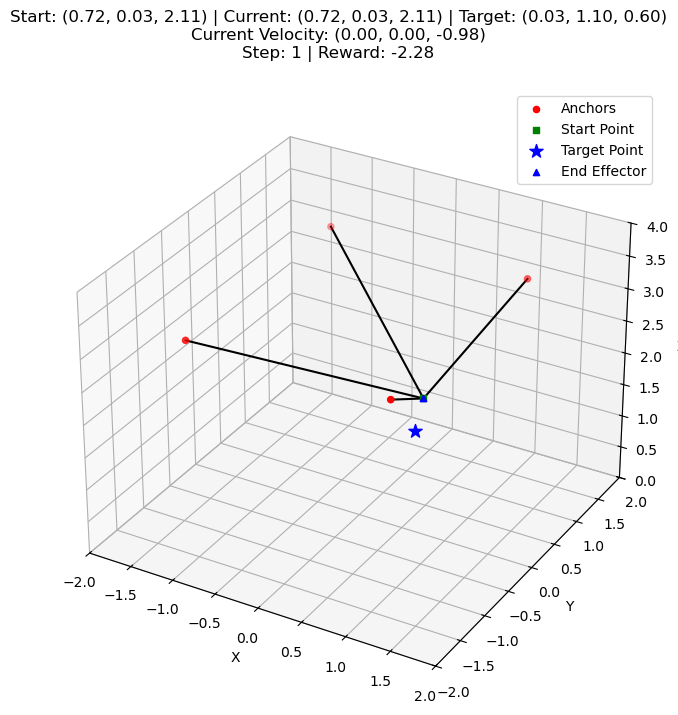

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 1: Total Reward = -4.032352805137634, Done: True, Steps: 12
Final observation: [[ 0.9280315   1.1702813   0.92140377  0.          0.          0.
  -0.4374336  -0.57415897  0.34998974]]
Saved GIF to cdpr4_gifs/ddpg/mi93o31c/episode_1.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 2: Total Reward = -4.639982687309384, Done: True, Steps: 14
Final observation: [[ 0.46332988  1.0082413   0.7987935   0.          0.          0.
  -0.6293724  -1.401778    2.2770553 ]]
Saved GIF to cdpr4_gifs/ddpg/mi93o31c/episode_2.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 3: Total Reward = -13.196612477302551, Done: True, Steps: 4
Final observation: [[1.0008984  0.14816232 1.8808725  0.         0.         0.
  0.57365096 0.48129547 0.61187774]]
Saved GIF to cdpr4_gifs/ddpg/mi93o31c/episode_3.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 4: Total Reward = -0.13130557537078857, Done: True, Steps: 4
Final observation: [[-0.00306405  0.19753413  0.15989928  0.          0.          0.
   0.7236803   1.1105467   2.3325312 ]]
Saved GIF to cdpr4_gifs/ddpg/mi93o31c/episode_4.gif


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Episode 5: Total Reward = 0.013823233544826508, Done: True, Steps: 16
Final observation: [[-0.01906193  0.31805137  1.8326211   0.          0.          0.
  -0.4945469   0.46022615  2.0694604 ]]
Saved GIF to cdpr4_gifs/ddpg/mi93o31c/episode_5.gif


In [6]:
train_single_DDPG()